<a href="https://colab.research.google.com/github/PrithiviRajMK/ScalerProjects/blob/main/Zee_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective
### Zee wants to know, 
*   Create a Recommender System to show personalized movie recommendations based on ratings given by a user and other users similar to them in order to improve user experience.

In [2]:
#Importing Drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Import Packages

In [3]:
# Import required packages
import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing Libs
import pandas as pd #data processing using DataFrames
import numpy as np #Numrical calculations
import re
from sklearn.preprocessing import LabelEncoder, StandardScaler 
#Plotting Libs
import matplotlib.pyplot as plt # plotting
import seaborn as sns # plotting
import plotly.express as px # plotting
#Statistics Libs
from scipy.stats import binom, poisson,expon # For Probability Distribution.
import plotly.figure_factory as ff # distplot 
from scipy.stats import ttest_ind, f_oneway, kruskal # numeric Vs catogerical
from scipy.stats import chi2_contingency
import scipy.stats as st# categorical Vs categorical
from datetime import datetime
from scipy.stats import pearsonr, spearmanr # numeric Vs numeric

from scipy.stats import kstest,levene,norm,shapiro # cdf
from statsmodels.graphics.gofplots import qqplot_2samples, qqplot

from statsmodels.distributions.empirical_distribution import ECDF
# Prec


#### Import & Load data

In [4]:
df_movies=  pd.read_fwf('/content/drive/MyDrive/Scaler Zee/zee-movies.dat',sep='\t', encoding='ISO-8859-1')
df_rating=  pd.read_fwf('/content/drive/MyDrive/Scaler Zee/zee-ratings.dat', encoding='ISO-8859-1')
df_users=  pd.read_fwf('/content/drive/MyDrive/Scaler Zee/zee-users.dat', encoding='ISO-8859-1')


# Unzipping Datasets
#Movies Dataset

In [5]:
df_movies.head()


,Movie ID::Title::Genres,Unnamed: 1,Unnamed: 2
0,1::Toy Story (1995)::Animation|Children's|Comedy,NaN,NaN
1,2::Jumanji (1995)::Adventure|Children's|Fantasy,NaN,NaN
2,3::Grumpier Old Men (1995)::Comedy|Romance,NaN,NaN
3,4::Waiting to Exhale (1995)::Comedy|Drama,NaN,NaN
4,5::Father of the Bride Part II (1995)::Comedy,NaN,NaN


In [6]:
# un zipping the data with Delimeter ::
df_movies[['MovieID','Title','Genres']] = df_movies['Movie ID::Title::Genres'].str.split('::',expand=True)
pattern = r'\((\d+)\)'
df_movies['Release_year'] = df_movies['Title'].str.extract(pattern)
df_movies['Title']=df_movies['Title'].str.replace(r'\(\d+\)', '').str.strip()
df_movies.drop(df_movies.columns[[0, 1, 2]], axis=1, inplace=True)

In [7]:
df_movies.head()

,MovieID,Title,Genres,Release_year
0,1,Toy Story,Animation|Children's|Comedy,1995
1,2,Jumanji,Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama,1995
4,5,Father of the Bride Part II,Comedy,1995


#Unzipping Rating Dataset

In [8]:
df_rating[['UserID','MovieID','Rating','Timestamp']] = df_rating['UserID::MovieID::Rating::Timestamp'].str.split('::',expand=True)
df_rating.drop('UserID::MovieID::Rating::Timestamp', axis=1, inplace=True)

In [9]:
df_rating.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


#Unzipping Users Data

In [10]:
df_users[['UserID','Gender','Age','Occupation','Zip-code']] = df_users['UserID::Gender::Age::Occupation::Zip-code'].str.split('::',expand=True)
df_users.drop('UserID::Gender::Age::Occupation::Zip-code', axis=1, inplace=True)

In [11]:
df_users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


### Description of the dataframe

In [12]:
df_movies.describe()

,MovieID,Title,Genres,Release_year
count,3883,3883,3858,3864
unique,3883,3841,360,81
top,1,Hamlet,Drama,1996
freq,1,5,830,344


In [13]:
df_rating.describe(include='all')

,UserID,MovieID,Rating,Timestamp
count,1000209,1000209,1000209,1000209
unique,6040,3706,5,458455
top,4169,2858,4,975528402
freq,2314,3428,348971,30


In [14]:
# only object type columns
df_users.describe(include='all')

,UserID,Gender,Age,Occupation,Zip-code
count,6040,6040,6040,6040,6040
unique,6040,2,7,21,3439
top,1,M,25,4,48104
freq,1,4331,2096,759,19


### Shape of the data

In [15]:
### Data shape
print("Zee Movies dataset has {} rows and {} columns.".format(df_movies.shape[0], df_movies.shape[1]))
print("Zee Users dataset has {} rows and {} columns.".format(df_users.shape[0], df_users.shape[1]))
print("Zee Rating dataset has {} rows and {} columns.".format(df_rating.shape[0], df_rating.shape[1]))

Zee Movies dataset has 3883 rows and 4 columns.
Zee Users dataset has 6040 rows and 5 columns.
Zee Rating dataset has 1000209 rows and 4 columns.


### Meta-Data of Dataset


In [16]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   MovieID       3883 non-null   object
 1   Title         3883 non-null   object
 2   Genres        3858 non-null   object
 3   Release_year  3864 non-null   object
dtypes: object(4)
memory usage: 121.5+ KB


In [17]:
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   UserID     1000209 non-null  object
 1   MovieID    1000209 non-null  object
 2   Rating     1000209 non-null  object
 3   Timestamp  1000209 non-null  object
dtypes: object(4)
memory usage: 30.5+ MB


In [18]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   UserID      6040 non-null   object
 1   Gender      6040 non-null   object
 2   Age         6040 non-null   object
 3   Occupation  6040 non-null   object
 4   Zip-code    6040 non-null   object
dtypes: object(5)
memory usage: 236.1+ KB


# Data Pre-processing

### Check for Missing Values

In [19]:
# Missing Values
null_values= pd.DataFrame({"Null Values" : df_movies.isna().sum(),
                           "Percentage Null Value": (df_movies.isna().sum()/(df_movies.shape[0])*(100))})
null_values

,Null Values,Percentage Null Value
MovieID,0,0.000000
Title,0,0.000000
Genres,25,0.643832
Release_year,19,0.489312


Genres has 25 Null values and Release_year also has 19 Null values.

In [20]:
#Viewing the Rows with NULL in Genres and Release_year
df_movies[df_movies.isnull().any(axis=1)]

,MovieID,Title,Genres,Release_year
62,63,Don't Be a Menace to South Central While Drink...,None,NaN
197,199,"Umbrellas of Cherbourg, The (Parapluies de Che...",None,1964
359,363,"Wonderful, Horrible Life of Leni Riefenstahl, ...",None,NaN
464,468,"Englishman Who Went Up a Hill, But Came Down a...",None,NaN
720,729,"Institute Benjamenta, or This Dream People Cal...",None,1995
740,750,Dr. Strangelove or: How I Learned to Stop Worr...,None,NaN
783,793,My Life and Times With Antonin Artaud (En comp...,None,NaN
787,797,"Old Lady Who Walked in the Sea, The (Vieille q...",None,NaN
1134,1150,"Return of Martin Guerre, The (Retour de Martin...",None,1982
1160,1176,"Double Life of Veronique, The (La Double Vie d...",None,1991


So We Need to remove 31(25 Genres + 6 Release_year) Movies from the dataframe since it has NULL values

In [21]:
df_movies = df_movies.dropna()


In [22]:
df_movies.isnull().sum().sum()

0

In [23]:
df_users.isnull().sum().sum()

0

In [24]:
df_rating.isnull().sum().sum()

0

In [25]:
movie_ratings = pd.merge(df_rating, df_movies, on='MovieID')
movie_ratings

,UserID,MovieID,Rating,Timestamp,Title,Genres,Release_year
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest,Drama,1975
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest,Drama,1975
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest,Drama,1975
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest,Drama,1975
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest,Drama,1975
...,...,...,...,...,...,...,...
996139,5949,2198,5,958846401,Modulations,Documentary,1998
996140,5675,2703,3,976029116,Broken Vessels,Drama,1998
996141,5780,2845,1,958153068,White Boys,Drama,1999
996142,5851,3607,5,957756608,One Little Indian,Comedy|Drama|Western,1973


In [26]:
rating_count=movie_ratings.groupby(['MovieID','Title'])['Rating'].count()
rc=rating_count.to_frame()
rc

,,Rating
MovieID,Title,
1,Toy Story,2077
10,GoldenEye,888
100,City Hall,128
1000,Curdled,20
1002,Ed's Next Move,8
...,...,...
994,Big Night,450
996,Last Man Standing,256
997,Caught,28


In [27]:
Consolidate_data = pd.merge(movie_ratings, df_users, on='UserID')
Consolidate_data

,UserID,MovieID,Rating,Timestamp,Title,Genres,Release_year,Gender,Age,Occupation,Zip-code
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest,Drama,1975,F,1,10,48067
1,1,661,3,978302109,James and the Giant Peach,Animation|Children's|Musical,1996,F,1,10,48067
2,1,914,3,978301968,My Fair Lady,Musical|Romance,1964,F,1,10,48067
3,1,3408,4,978300275,Erin Brockovich,Drama,2000,F,1,10,48067
4,1,2355,5,978824291,"Bug's Life, A",Animation|Children's|Comedy,1998,F,1,10,48067
...,...,...,...,...,...,...,...,...,...,...,...
996139,4211,3791,2,965319075,Footloose,Drama,1984,M,45,5,77662
996140,4211,3806,3,965319138,MacKenna's Gold,Western,1969,M,45,5,77662
996141,4211,3840,4,965319197,Pumpkinhead,Horror,1988,M,45,5,77662
996142,4211,3766,2,965319138,Missing in Action,Action|War,1984,M,45,5,77662


<Axes: >

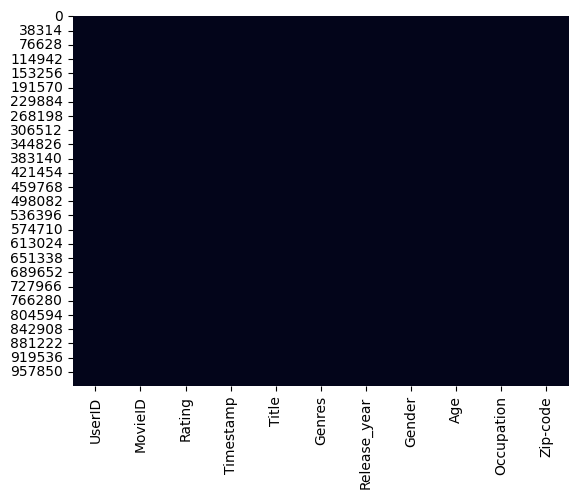

In [28]:
sns.heatmap(Consolidate_data.isnull(), cbar=False)

#Exploratory Data Analysis


  UserID MovieID Rating  Timestamp
0      1    1193      5  978300760
1      1     661      3  978302109
2      1     914      3  978301968
3      1    3408      4  978300275
4      1    2355      5  978824291
unique UserID: 6040
unique MovieID: 3706
avg. distinct item count per user: 165.5975165562914
avg. distinct user count per Movie: 269.88909875876953


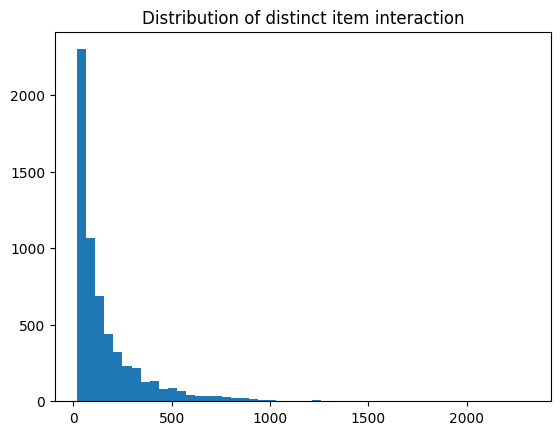

In [29]:

print(df_rating.head(5))
print('unique UserID:',len(list(df_rating['UserID'].unique())))
print('unique MovieID:',len(list(df_rating['MovieID'].unique())))
print('avg. distinct item count per user:',df_rating.groupby('UserID')['MovieID'].nunique().mean())
print('avg. distinct user count per Movie:',df_rating.groupby('MovieID')['UserID'].nunique().mean())
user_item_interaction = df_rating.groupby('UserID')['MovieID'].nunique()
plt.hist(user_item_interaction, bins = 50)
plt.title('Distribution of distinct item interaction')
plt.show()

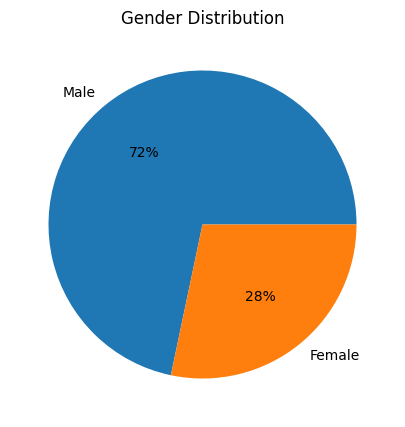

In [30]:
#Gender Distribution of Users
plt.figure(figsize=(15,5))
plt.pie(df_users['Gender'].value_counts(),labels=['Male','Female'], autopct='%.0f%%')
plt.title('Gender Distribution')
plt.show()

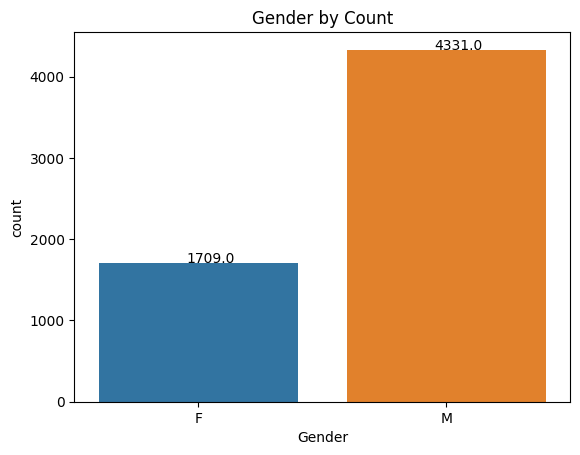

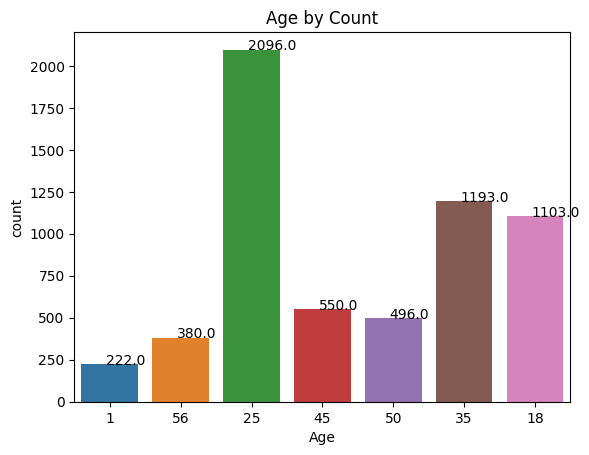

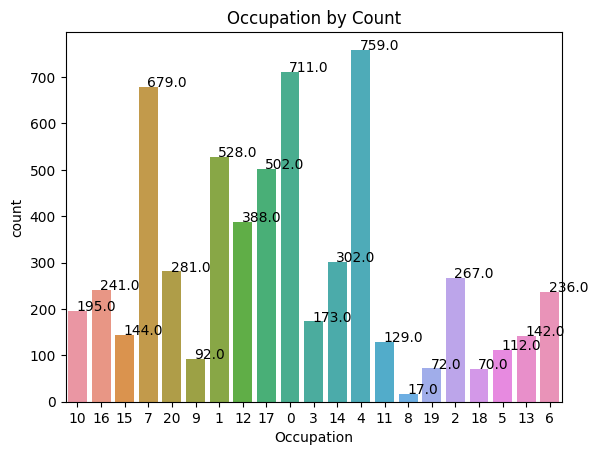

In [31]:
#plotting Age and ocuupation Groups
Sub_col=['Gender','Age','Occupation']
# Count plot of attributes
for col in Sub_col:
  ax = sns.countplot(data=df_users, x=col)
  plt.title(f"{col} by Count")
  for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x()+0.35, p.get_height()+0.05))
  plt.show()
  print()

#Top 5 Users Group
* college/grad student
*  "other" or not specified
* academic/educator
* executive/managerial
* technician/engineer

#Last 5 Users Groups
* customer service
* tradesman/craftsman
* unemployed
* farmer
* homemaker
* lawyer
* retired


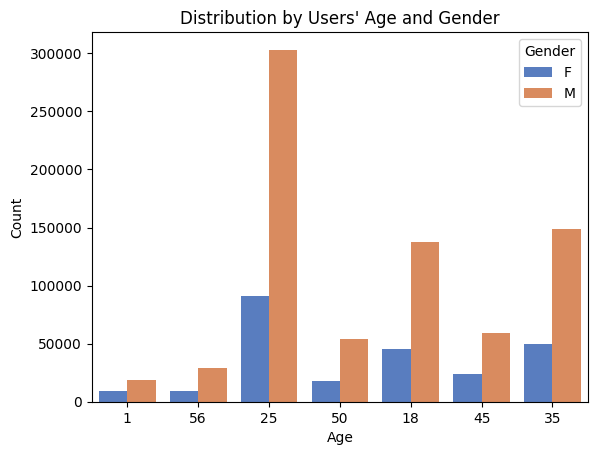

In [32]:

# Countplot of ratings by users' age and gender
sns.countplot(x='Age', hue='Gender', data=Consolidate_data, palette='muted')
plt.title('Distribution by Users\' Age and Gender')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


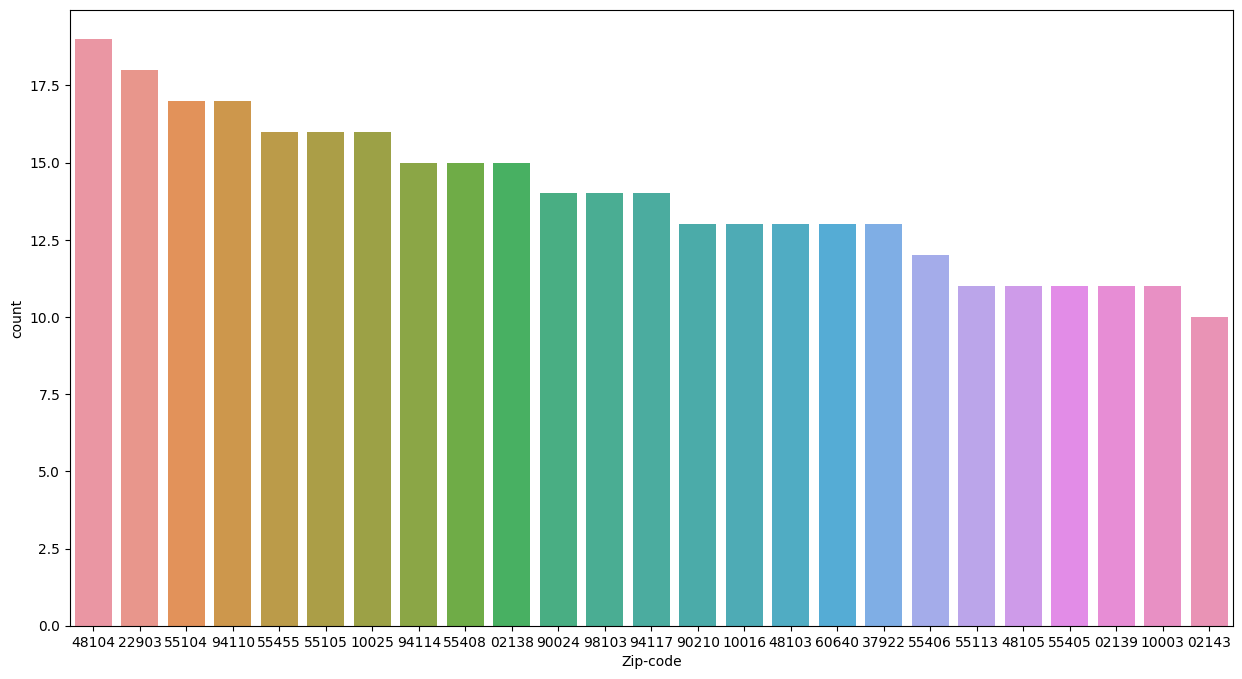

In [33]:
#Plotting Top 20 Geo Location 
plt.figure(figsize=(15,8))
sns.countplot(data=df_users, x='Zip-code', order=df_users['Zip-code'].value_counts().iloc[:25].index)
plt.show()

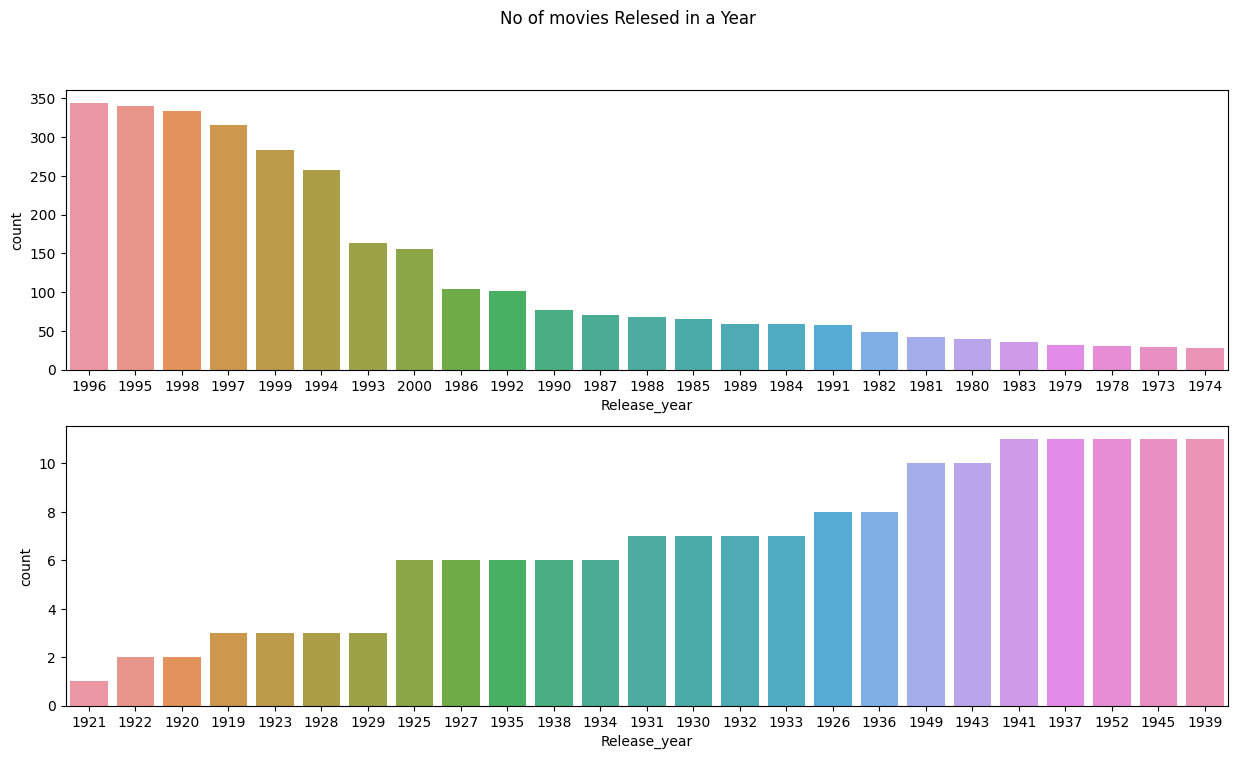

In [34]:
#plotting the Top 20 and last 20 Release years
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))

# plot data on the first subplot
sns.countplot(data=df_movies, x='Release_year',order=df_movies['Release_year'].value_counts().iloc[:25].index,ax=axes[0])

# plot data on the second subplot
sns.countplot(data=df_movies, x='Release_year',order=df_movies['Release_year'].value_counts(ascending=True).iloc[:25].index,ax=axes[1])

# set overall title for the figure
fig.suptitle("No of movies Relesed in a Year")

# show the plot
plt.show()

In [35]:
df_rating = df_rating.astype({'Timestamp':'int'})
df_rating['Hour'] = df_rating['Timestamp'].apply(lambda x: datetime.fromtimestamp(x).hour)
df_rating.head()

,UserID,MovieID,Rating,Timestamp,Hour
0,1,1193,5,978300760,22
1,1,661,3,978302109,22
2,1,914,3,978301968,22
3,1,3408,4,978300275,22
4,1,2355,5,978824291,23


In [37]:
# duplicates
movie_genres = df_movies.copy()
movie_genres['Genres'] = movie_genres['Genres'].str.split('|')
movie_genres = movie_genres.explode('Genres')
movie_genres.head()

,MovieID,Title,Genres,Release_year
0,1,Toy Story,Animation,1995
0,1,Toy Story,Children's,1995
0,1,Toy Story,Comedy,1995
1,2,Jumanji,Adventure,1995
1,2,Jumanji,Children's,1995


In [38]:
arr=movie_genres.Genres.unique()
arr.sort()
arr

array(['', 'A', 'Acti', 'Action', 'Adv', 'Advent', 'Adventu', 'Adventur',
       'Adventure', 'Animati', 'Animation', 'Chi', 'Chil', 'Childr',
       'Childre', 'Children', "Children'", "Children's", 'Com', 'Come',
       'Comed', 'Comedy', 'Crime', 'D', 'Docu', 'Documen', 'Document',
       'Documenta', 'Documentary', 'Dr', 'Dram', 'Drama', 'F', 'Fant',
       'Fantas', 'Fantasy', 'Film-Noir', 'Horr', 'Horro', 'Horror',
       'Music', 'Musical', 'Mystery', 'R', 'Ro', 'Rom', 'Roma', 'Roman',
       'Romance', 'S', 'Sci', 'Sci-', 'Sci-F', 'Sci-Fi', 'Th', 'Thri',
       'Thrille', 'Thriller', 'Wa', 'War', 'We', 'Wester', 'Western'],
      dtype=object)

In [39]:
mapping = {'': '', 'A': 'Action', 'Acti': 'Action', 'Adv': 'Adventure', 'Advent': 'Adventure', 'Adventu': 'Adventure', 'Adventur': 'Adventure', 'Adventure': 'Adventure', 'Animati': 'Animation', 'Animation': 'Animation', 'Chi': 'Children', 'Chil': 'Children', 'Childr': 'Children', 'Childre': 'Children', 'Children': 'Children', "Children'": "Children", "Children's": "Children", 'Com': 'Comedy', 'Come': 'Comedy', 'Comed': 'Comedy', 'Comedy': 'Comedy', 'Crime': 'Crime', 'D': 'Documentary', 'Docu': 'Documentary', 'Documen': 'Documentary', 'Document': 'Documentary', 'Documenta': 'Documentary', 'Documentary': 'Documentary', 'Dr': 'Drama', 'Dram': 'Drama', 'Drama': 'Drama', 'F': 'Fantasy', 'Fant': 'Fantasy', 'Fantas': 'Fantasy', 'Fantasy': 'Fantasy', 'Film-Noir': 'Film-Noir', 'Horr': 'Horror', 'Horro': 'Horror', 'Horror': 'Horror', 'Music': 'Musical', 'Musical': 'Musical', 'Mystery': 'Mystery', 'R': 'Romance', 'Ro': 'Romance', 'Rom': 'Romance', 'Roma': 'Romance', 'Roman': 'Romance', 'Romance': 'Romance', 'S': 'Sci-Fi', 'Sci': 'Sci-Fi', 'Sci-': 'Sci-Fi', 'Sci-F': 'Sci-Fi', 'Sci-Fi': 'Sci-Fi', 'Th': 'Thriller', 'Thri': 'Thriller', 'Thrille': 'Thriller', 'Thriller': 'Thriller', 'Wa': 'War', 'War': 'War', 'We': 'Western', 'Wester': 'Western', 'Western': 'Western'}

# replace the values in the 'genre' column using the mapping
movie_genres['Genres'] = movie_genres['Genres'].replace(mapping)


In [40]:
arr=movie_genres.Genres.unique()
arr.sort()
arr

array(['', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western'], dtype=object)

In [41]:
movie_genres['Genres'].value_counts()

Drama          1582
Comedy         1189
Action          503
Thriller        488
Romance         462
Horror          340
Adventure       282
Sci-Fi          265
Children        249
Crime           210
War             139
Documentary     127
Musical         113
Mystery         105
Animation       104
Western          68
Fantasy          63
Film-Noir        44
                  8
Name: Genres, dtype: int64

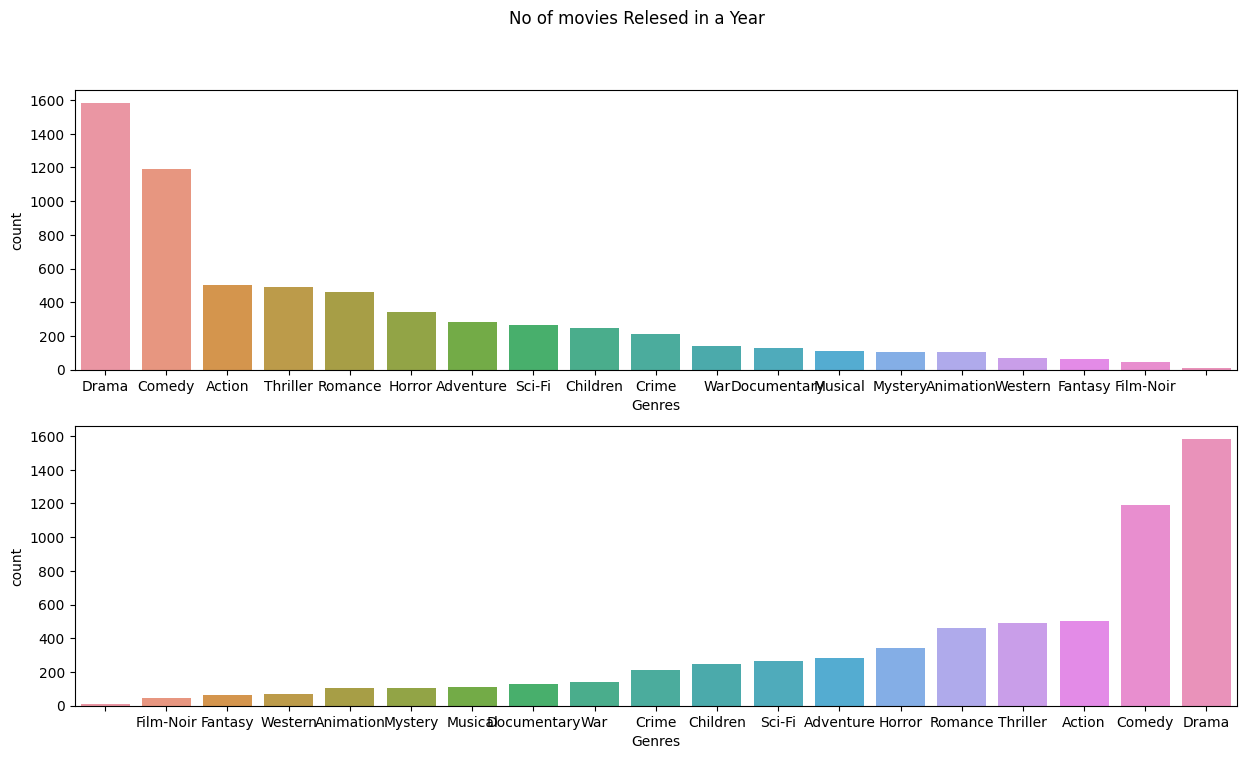

In [42]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))

# plot data on the first subplot
sns.countplot(data=movie_genres, x='Genres',order=movie_genres['Genres'].value_counts().iloc[:25].index,ax=axes[0])

# plot data on the second subplot
sns.countplot(data=movie_genres, x='Genres',order=movie_genres['Genres'].value_counts(ascending=True).iloc[:25].index,ax=axes[1])

# set overall title for the figure
fig.suptitle("No of movies Relesed in a Year")

# show the plot
plt.show()

In [43]:
movie_genres[movie_genres['Genres']=='']

,MovieID,Title,Genres,Release_year
255,258,"Kid in King Arthur's Court, A",,1995
262,265,Like Water for Chocolate (Como agua para choco...,,1992
1187,1205,"Transformers: The Movie, The",,1986
1286,1306,Until the End of the World (Bis ans Ende der W...,,1991
1339,1360,Identification of a Woman (Identificazione di ...,,1982
2073,2142,"American Tail: Fievel Goes West, An",,1991
2636,2705,"Late August, Early September (Fin août, début ...",,1998
3794,3864,Godzilla 2000 (Gojira ni-sen mireniamu),,1999


In [45]:
movie_genres.loc[movie_genres['Genres'] == '', 'MovieID']

255      258
262      265
1187    1205
1286    1306
1339    1360
2073    2142
2636    2705
3794    3864
Name: MovieID, dtype: object

#### **Observation**: *There is no missing value in the given dataset for any attribute*

In [49]:
print(df_movies[df_movies["MovieID"]=='2858'])

     MovieID            Title        Genres Release_year
2789    2858  American Beauty  Comedy|Drama         1999


In [50]:
movie_ratings = pd.merge(df_rating, df_movies, on='MovieID')
movie_ratings

,UserID,MovieID,Rating,Timestamp,Hour,Title,Genres,Release_year
0,1,1193,5,978300760,22,One Flew Over the Cuckoo's Nest,Drama,1975
1,2,1193,5,978298413,21,One Flew Over the Cuckoo's Nest,Drama,1975
2,12,1193,4,978220179,23,One Flew Over the Cuckoo's Nest,Drama,1975
3,15,1193,4,978199279,18,One Flew Over the Cuckoo's Nest,Drama,1975
4,17,1193,5,978158471,6,One Flew Over the Cuckoo's Nest,Drama,1975
...,...,...,...,...,...,...,...,...
996139,5949,2198,5,958846401,18,Modulations,Documentary,1998
996140,5675,2703,3,976029116,15,Broken Vessels,Drama,1998
996141,5780,2845,1,958153068,17,White Boys,Drama,1999
996142,5851,3607,5,957756608,3,One Little Indian,Comedy|Drama|Western,1973


In [52]:
rating_count = movie_ratings.groupby(['MovieID','Title'])["Rating"].count().sort_values(ascending=False)
rating_count

MovieID  Title                                         
2858     American Beauty                                   3428
260      Star Wars: Episode IV - A New Hope                2991
1196     Star Wars: Episode V - The Empire Strikes Back    2990
1210     Star Wars: Episode VI - Return of the Jedi        2883
480      Jurassic Park                                     2672
                                                           ... 
3237     Kestrel's Eye (Falkens öga)                          1
2254     Choices                                              1
601      Wooden Man's Bride, The (Wu Kui)                     1
1908     Resurrection Man                                     1
1386     Terror in a Texas Town                               1
Name: Rating, Length: 3682, dtype: int64

### Pearson Recommended

In [53]:

# calculate the mean rating for each movie
mean_ratings = movie_ratings.groupby(['Title'])['Rating'].mean().reset_index()
print(mean_ratings)

# create a pivot table with movie titles as rows and user ratings as columns
user_ratings = movie_ratings.pivot_table(index='UserID', columns='Title', values='Rating')

# fill in missing values with zeros
user_ratings = user_ratings.fillna(0)
print(user_ratings.head())

# calculate the Pearson Correlation between all pairs of movies
correlations = np.corrcoef(user_ratings.T)
print(correlations)

                                    Title         Rating
0                         $1,000,000 Duck   6.868525e+34
1                           'Night Mother   7.622188e+67
2                      'Til There Was You   4.121987e+49
3                             'burbs, The  1.460150e+300
4                  ...And Justice for All  1.182635e+196
...                                   ...            ...
3635                 Zed & Two Noughts, A   8.808429e+26
3636                          Zero Effect  1.170580e+298
3637  Zero Kelvin (Kjærlighetens kjøtere)   1.700000e+01
3638                     Zeus and Roxanne   1.404841e+21
3639                             eXistenZ            inf

[3640 rows x 2 columns]
Title   $1,000,000 Duck  'Night Mother  'Til There Was You  'burbs, The  \
UserID                                                                    
1                   0.0            0.0                 0.0          0.0   
10                  0.0            0.0                 0.0        

In [54]:

# get the index of the movie in the correlations matrix
movie_idx = mean_ratings[mean_ratings['Title'] == "Toy Story"].index[0]
print(movie_idx)
# get the Pearson Correlation coefficients for the selected movie
corrs = correlations[movie_idx]
print(corrs)

# create a dataframe with the correlations and movie titles
similar_movies = pd.DataFrame({'Title': user_ratings.columns, 'correlation': corrs})
similar_movies.head()


3351
[0.05174442 0.04210762 0.04271477 ... 0.01268849 0.04293014 0.08088685]


,Title,correlation
0,"$1,000,000 Duck",0.051744
1,'Night Mother,0.042108
2,'Til There Was You,0.042715
3,"'burbs, The",0.138013
4,...And Justice for All,0.050579


In [55]:

# remove movies with a correlation of 1 (i.e., the selected movie itself)
similar_movies = similar_movies[(similar_movies['Title']!='Toy Story') & (similar_movies['correlation'] < 1)]

# sort the movies by descending correlation
popular_similar_movies = pd.merge(similar_movies, rc, on='Title')
Popular_movies=pd.merge(popular_similar_movies,df_movies, on='Title')
Popular_movies = Popular_movies.sort_values(by=['correlation','Rating'], ascending=False)


# select the top 5 most similar movies
recommendations = Popular_movies.head(5)

# print the recommendations
print("Recommended movies based on Pearson Correlation for Toy Story")
recommendations

Recommended movies based on Pearson Correlation for Toy Story


,Title,correlation,Rating,MovieID,Genres,Release_year
3482,Toy Story 2,0.487370,1585,3114,Animation|Children's|Comedy,1999
90,Aladdin,0.470753,1351,588,Animation|Children's|Comedy|Musical,1992
1979,"Lion King, The",0.411131,1121,364,Animation|Children's|Musical,1994
1437,Groundhog Day,0.407547,2278,1265,Comedy|Romance,1993
560,"Bug's Life, A",0.402679,1703,2355,Animation|Children's|Comedy,1998




###Cosine Similarity- Recommendation System

In [56]:

from sklearn.metrics.pairwise import cosine_similarity
# merge the two dataframes on movieId
movie_ratings = pd.merge(df_rating,df_movies, on='MovieID')

# create a pivot table with movie titles as rows and user ratings as columns
user_ratings = movie_ratings.pivot_table(index='UserID', columns='Title', values='Rating')

# fill in missing values with zeros
user_ratings = user_ratings.fillna(0)

# calculate the cosine similarity between all pairs of movies
item_similarity = cosine_similarity(user_ratings.T)
print(item_similarity)
# calculate the cosine similarity between all pairs of users
user_similarity = cosine_similarity(user_ratings)
user_similarity


[[1.         0.07235746 0.03701053 ... 0.         0.12024178 0.02700277]
 [0.07235746 1.         0.11528952 ... 0.         0.         0.07780705]
 [0.03701053 0.11528952 1.         ... 0.         0.04752635 0.0632837 ]
 ...
 [0.         0.         0.         ... 1.         0.         0.04564448]
 [0.12024178 0.         0.04752635 ... 0.         1.         0.04433508]
 [0.02700277 0.07780705 0.0632837  ... 0.04564448 0.04433508 1.        ]]


array([[1.        , 0.26113546, 0.12396703, ..., 0.15926709, 0.11935626,
        0.15362375],
       [0.26113546, 1.        , 0.23365026, ..., 0.14911052, 0.11997866,
        0.22557756],
       [0.12396703, 0.23365026, 1.        , ..., 0.20430203, 0.11352239,
        0.28505089],
       ...,
       [0.15926709, 0.14911052, 0.20430203, ..., 1.        , 0.18657496,
        0.2286199 ],
       [0.11935626, 0.11997866, 0.11352239, ..., 0.18657496, 1.        ,
        0.10055099],
       [0.15362375, 0.22557756, 0.28505089, ..., 0.2286199 , 0.10055099,
        1.        ]])

In [57]:
# get the movie name from the user
movie_name = input("Enter a movie name: ")

# get the index of the movie in the pivot table
movie_idx = user_ratings.columns.get_loc(movie_name)

# calculate the item similarity scores for the selected movie
item_scores = list(enumerate(item_similarity[movie_idx]))

# sort the scores by descending order
item_scores = sorted(item_scores, key=lambda x: x[1], reverse=True)

# select the top 5 most similar movies
item_recommendations = item_scores[1:6]

# get the user ID from the user
user_id = int(input("Enter a user ID: "))

# get the user similarity scores for the selected user
user_scores = list(enumerate(user_similarity[user_id]))

# sort the scores by descending order
user_scores = sorted(user_scores, key=lambda x: x[1], reverse=True)

# select the top 5 most similar users
user_recommendations = user_scores[1:6]

# print the recommendations
print("Item-based recommendations based on cosine similarity for", movie_name, ":")
for i, score in item_recommendations:
    print(df_movies.loc[df_movies['Title'] == user_ratings.columns[i], 'Title'].values[0])

print("\nUser-based recommendations based on cosine similarity for user", user_id, ":")
for i, score in user_recommendations:
    # get the movies that the similar users have rated highly
    top_movies = user_ratings.iloc[i].nlargest(5).index
    print("User", i, ":", top_movies.values)


Enter a movie name: Liar Liar
Enter a user ID: 100
Item-based recommendations based on cosine similarity for Liar Liar :
Mrs. Doubtfire
Ace Ventura: Pet Detective
Dumb & Dumber
Home Alone
Wayne's World

User-based recommendations based on cosine similarity for user 100 :
User 2364 : ['Alien' 'American Beauty' 'Crow, The' 'Dark City' 'Fifth Element, The']
User 1226 : ['Alien' 'Blair Witch Project, The' 'City of Lost Children, The' 'Dracula'
 'Exorcist, The']
User 3336 : ['Alien' 'American Werewolf in London, An' 'Army of Darkness'
 "Brain That Wouldn't Die, The" 'Chinatown']
User 3370 : ['Bride of Frankenstein' 'Dracula' 'Eraserhead'
 'Evil Dead II (Dead By Dawn)' 'Exorcist, The']
User 3913 : ['King Kong' 'Alien' 'Aliens' 'Apocalypse Now' 'Being John Malkovich']


In [58]:

from scipy.sparse import csr_matrix
# create a sparse matrix in CSR format from the pivot table
user_ratings_sparse = csr_matrix(user_ratings.values)

# calculate the cosine similarity between all pairs of movies
item_similarity = cosine_similarity(user_ratings_sparse.T)

# calculate the cosine similarity between all pairs of users
user_similarity = cosine_similarity(user_ratings_sparse)

# get the movie name from the user
movie_name = input("Enter a movie name: ")

# get the index of the movie in the pivot table
movie_idx = user_ratings.columns.get_loc(movie_name)

# calculate the item similarity scores for the selected movie
item_scores = list(enumerate(item_similarity[movie_idx]))

# sort the scores by descending order
item_scores = sorted(item_scores, key=lambda x: x[1], reverse=True)

# select the top 5 most similar movies
item_recommendations = item_scores[1:6]

# get the user ID from the user
user_id = int(input("Enter a user ID: "))

# get the user similarity scores for the selected user
user_scores = list(enumerate(user_similarity[user_id]))

# sort the scores by descending order
user_scores = sorted(user_scores, key=lambda x: x[1], reverse=True)

# select the top 5 most similar users
user_recommendations = user_scores[1:6]

# print the recommendations
print("Item-based recommendations based on cosine similarity for", movie_name, ":")
for i, score in item_recommendations:
    print(df_movies.loc[df_movies['Title'] == user_ratings.columns[i], 'Title'].values[0])

print("\nUser-based recommendations based on cosine similarity for user", user_id, ":")
for i, score in user_recommendations:
    # get the movies that the similar users have rated highly
    top_movies = user_ratings.iloc[i].nlargest(5).index
    print("User", i, ":", top_movies.values)

Enter a movie name: Toy Story
Enter a user ID: 10
Item-based recommendations based on cosine similarity for Toy Story :
Toy Story 2
Groundhog Day
Aladdin
Bug's Life, A
Back to the Future

User-based recommendations based on cosine similarity for user 10 :
User 3980 : ['Airplane!' 'And Now for Something Completely Different' 'Animal House'
 'Annie Hall' 'Back to the Future']
User 1609 : ['Airplane!' 'Bachelor Party' 'Back to the Future' 'Better Off Dead...'
 'Blues Brothers, The']
User 845 : ['Back to School' 'Back to the Future' 'Back to the Future Part II'
 'Blues Brothers, The' 'Breakfast Club, The']
User 3638 : ['Airplane!' 'Animal House' 'Being There' 'Blazing Saddles'
 'Blues Brothers, The']
User 2704 : ['Airplane II: The Sequel' 'Airplane!' 'Army of Darkness'
 'Austin Powers: International Man of Mystery'
 'Big Trouble in Little China']


### KNN Neighbour Recommendation Systems


In [59]:

from scipy.sparse import csr_matrix
data = pd.merge(df_movies,df_rating)
data = data.iloc[:1000000,:]
user_movie_table = data.pivot_table(index = ["Title"],columns = ["UserID"],values = "Rating").fillna(0)
user_movie_table.head(10)

UserID,1,10,100,1000,1001,1002,1003,1004,1005,1006,...,990,991,992,993,994,995,996,997,998,999
Title,,,,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Night Mother,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Til There Was You,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"'burbs, The",0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...And Justice for All,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
1-900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10 Things I Hate About You,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101 Dalmatians,0.0,0.0,0.0,4.0,3.0,0.0,0.0,22.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12 Angry Men,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0


In [60]:
# We choose random movie.
query_index = np.random.choice(user_movie_table.shape[0])
print("Choosen Movie is: ",user_movie_table.index[query_index])

Choosen Movie is:  Last Detail, The


In [61]:

from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
user_movie_table_matrix = csr_matrix(user_movie_table.values)
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(user_movie_table_matrix)
distances, indices = model_knn.kneighbors(user_movie_table.iloc[query_index,:].values.reshape(1,-1), n_neighbors = 6)

In [62]:
movie = []
distance = []

for i in range(0, len(distances.flatten())):
    if i != 0:
        movie.append(user_movie_table.index[indices.flatten()[i]])
        distance.append(distances.flatten()[i])    

m=pd.Series(movie,name='movie')
d=pd.Series(distance,name='distance')
recommend = pd.concat([m,d], axis=1)
recommend = recommend.sort_values('distance',ascending=False)

print('Recommendations for {0}:\n'.format(user_movie_table.index[query_index]))
for i in range(0,recommend.shape[0]):
    print('{0}: {1}, with distance of {2}'.format(i, recommend["movie"].iloc[i], recommend["distance"].iloc[i]))

Recommendations for Last Detail, The:

0: Melvin and Howard, with distance of 0.6501533408086845
1: Last Picture Show, The, with distance of 0.6499308755525153
2: Atlantic City, with distance of 0.6379542440909282
3: Network, with distance of 0.6363855519959225
4: Carnal Knowledge, with distance of 0.6018790696955747


###Matrix Factrorization


In [64]:
Consolidate_data = Consolidate_data.astype({"MovieID": int, "UserID": int})
#Creating the rating matrix (rows as movies, columns as users)
ratings_mat = np.ndarray(shape=(np.max(Consolidate_data.MovieID.values), int(np.max(Consolidate_data.UserID.values))), dtype=np.uint8)
     

In [66]:

# ratings_mat[final_df.MovieID.values-1, final_df.UserID.values-1] = final_df.Rating.values
ratings_mat[Consolidate_data.MovieID.values-1, int(np.max(Consolidate_data.UserID.values))-1] = Consolidate_data.Rating.values

In [67]:

#Normalizing the matrix(subtract mean off)
normalised_mat = ratings_mat - np.asarray([(np.mean(ratings_mat, 1))]).T

In [68]:

#Computing the Singular Value Decomposition (SVD)
A = normalised_mat.T / np.sqrt(ratings_mat.shape[0] - 1)
U, S, V = np.linalg.svd(A)

In [69]:

#Function to calculate the cosine similarity (sorting by most similar and returning the top N)
def top_cosine_similarity(final_df, movie_id, top_n=10):
    index = movie_id - 1 # Movie id starts from 1 in the dataset
    movie_row = final_df[index, :]
    magnitude = np.sqrt(np.einsum('ij, ij -> i', final_df, final_df))
    similarity = np.dot(movie_row, final_df.T) / (magnitude[index] * magnitude)
    sort_indexes = np.argsort(-similarity)
    return sort_indexes[:top_n]
     

In [74]:
# Function to print top N similar movies
def print_similar_movies(movie_data, movie_id, top_indexes):
    print('Recommendations for {0}: \n'.format(
    movie_data[movie_data.MovieID == movie_id].Title.values[0]))
    for id in top_indexes + 1:
        print(movie_data[movie_data.MovieID == id].Title.values[0])
        print(id)

In [75]:
#k-principal components to represent movies, movie_id to find recommendations, top_n print n results        
k = 50
movie_id = 1 
top_n = 10
sliced = V.T[:, :k] # representative data
indexes = top_cosine_similarity(sliced, movie_id, top_n)

#Printing the top N similar movies
print_similar_movies(Consolidate_data, movie_id, indexes)

Recommendations for Toy Story: 

Toy Story
1
Full Metal Jacket
1222
Joe's Apartment
829
Big Night
994
H.O.T.S.
3804
Year My Voice Broke, The
3329


IndexError: ignored

In [77]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 KB 46.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp39-cp39-linux_x86_64.whl size=3195776 sha256=053bd5c45f7325316190a52cc396e20f4e4332143f50de4267e6ddca64ba5968
  Stored in directory: /root/.cache/pip/wheels/c6/3a/46/9b17b3512bdf283c6cb84f59929cdd5199d4e754d596d22784
Successfully built scikit-surprise


In [78]:
from surprise import SVD
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate

import pandas as pd
from surprise import SVD
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse


In [79]:

# Load the dataset
data = Dataset.load_builtin('ml-1m')

# Define the SVD algorithm
algo = SVD()

Dataset ml-1m could not be found. Do you want to download it? [Y/n] Y
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-1m.zip...
Done! Dataset ml-1m has been saved to /root/.surprise_data/ml-1m


In [80]:
 #Evaluate the performance of the algorithm using cross validation
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Train the algorithm on the entire dataset
trainset = data.build_full_trainset()
algo.fit(trainset)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8725  0.8735  0.8753  0.8740  0.8726  0.8736  0.0010  
MAE (testset)     0.6849  0.6862  0.6866  0.6858  0.6856  0.6858  0.0006  
Fit time          15.10   13.58   13.54   14.09   15.47   14.36   0.79    
Test time         3.14    2.71    2.87    2.69    5.29    3.34    0.99    


In [81]:

# Split the data into training and testing sets
trainset, testset = train_test_split(data, test_size=0.25)

In [82]:
algo.fit(trainset)


In [83]:

predictions = algo.test(testset)
print('RMSE', rmse(predictions))

RMSE: 0.8789
RMSE 0.8789348496254257


In [84]:

from surprise import accuracy

In [85]:


# Calculate RMSE
rmse = accuracy.rmse(predictions)
print(rmse)

RMSE: 0.8789
0.8789348496254257


In [86]:

# Calculate MAPE
mape = accuracy.mae(predictions)
print(mape)

MAE:  0.6901
0.6901404117835108


In [87]:

from sklearn.metrics import mean_absolute_percentage_error
     

In [88]:
y_true = [r[2] for r in testset]
test_pred = algo.test(testset)
y_pred = [pred.est for pred in test_pred]
     

In [89]:
mape = mean_absolute_percentage_error(y_true, y_pred)
print('MAPE:', mape)

MAPE: 0.2660471176424734


In [90]:
from surprise import Dataset, Reader
from surprise import SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

# # Load the dataset
# file_path = 'path/to/dataset/file'
# reader = Reader(line_format='user item rating', sep='::', rating_scale=(1, 5), skip_lines=1)
# data = Dataset.load_from_file(file_path, reader=reader)

data = Dataset.load_builtin('ml-1m')
# Split the dataset into training and test sets
trainset, testset = train_test_split(data, test_size=0.1, random_state=42)

# Train the model with d=4
model = SVD(n_factors=4, random_state=42)
model.fit(trainset)

# Make predictions on the test set
predictions = model.test(testset)

# Evaluate the model's performance using RMSE and MAE
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)
print(f'RMSE: {rmse}, MAE: {mae}')


RMSE: 0.8761
MAE:  0.6896
RMSE: 0.8760715554132782, MAE: 0.6896360904788907


In [92]:
from surprise import Reader, Dataset
from surprise import KNNBasic
from surprise import accuracy
from surprise.model_selection import train_test_split

# load data
reader = Reader(line_format='user item rating timestamp', sep='::', skip_lines=1)
data = Dataset.load_from_file('/content/drive/MyDrive/Scaler Zee/zee-ratings.dat', reader=reader)

# train-test split
trainset, testset = train_test_split(data, test_size=0.1)

# user-based collaborative filtering with pearson correlation similarity measure
sim_options = {'name': 'pearson', 'user_based': True}
algo = KNNBasic(k=40, sim_options=sim_options)

# fit the model
algo.fit(trainset)

# predict ratings for testset
predictions = algo.test(testset)

# calculate RMSE and MAE
accuracy.rmse(predictions)
accuracy.mae(predictions)

# get top-n recommendations for a user
user_id = 1
n = 10
user_items = set([item_id for (item_id, _) in trainset.ur[user_id]])
all_items = set([item_id for item_id in algo.trainset.ir.keys()])
remaining_items = all_items - user_items
predictions = [(item_id, algo.predict(user_id, item_id).est) for item_id in remaining_items]
top_n = sorted(predictions, key=lambda x: x[1], reverse=True)[:n]


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9559
MAE:  0.7618


In [101]:
user_movie_Rating = Consolidate_data.pivot_table(index = ["UserID"],columns = ["Title"],values = "Rating").fillna(0)
user_movie_Rating.head(10)

Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin (Kjærlighetens kjøtere),Zeus and Roxanne,eXistenZ
UserID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
user_movie_Rating.shape

(6040, 3640)

In [103]:
X = user_movie_Rating.values.T
X.shape

(3640, 6040)

### Iplementation of SVD


In [105]:
import sklearn
from sklearn.decomposition import TruncatedSVD

SVD = TruncatedSVD(n_components=12, random_state=17)
matrix = SVD.fit_transform(X)
matrix.shape

(3640, 12)

In [106]:
# Creating correlation Coefficient matrix
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)
corr = np.corrcoef(matrix)
corr.shape

(3640, 3640)

In [107]:
movie_title = user_movie_Rating.columns
movie_title_list = list(movie_title)
selected_movie = movie_title_list.index("Aladdin")
print(selected_movie)

87


In [108]:
selected_movie_hands  = corr[selected_movie]
list(movie_title[(selected_movie_hands >= 0.9)])

['Aladdin',
 'American Tail, An',
 'Antz',
 'Beauty and the Beast',
 'Bedknobs and Broomsticks',
 'Borrowers, The',
 'Boy Who Could Fly, The',
 "Bug's Life, A",
 "Charlotte's Web",
 'Cinderella',
 'Escape to Witch Mountain',
 'Fantasia',
 'Fantasia 2000',
 'Fly Away Home',
 'Goonies, The',
 'Grease',
 'Great Muppet Caper, The',
 'Heart and Souls',
 'Hercules',
 'Honey, I Shrunk the Kids',
 'Hook',
 'Hunchback of Notre Dame, The',
 'Indian in the Cupboard, The',
 'Iron Giant, The',
 'James and the Giant Peach',
 'Jumanji',
 'Lady and the Tramp',
 'Lion King, The',
 'Little Mermaid, The',
 'Mary Poppins',
 'Matilda',
 "Midsummer Night's Dream, A",
 'Mulan',
 'Muppet Christmas Carol, The',
 'Muppet Movie, The',
 'Muppet Treasure Island',
 'Muppets From Space',
 'Muppets Take Manhattan, The',
 'NeverEnding Story, The',
 'Nightmare Before Christmas, The',
 'Peter Pan',
 'Prince of Egypt, The',
 'Road to El Dorado, The',
 'Santa Claus: The Movie',
 'Santa Clause, The',
 'Sound of Music, The'

1. Users of which age group have watched and rated the most number of movies?
   * 18-24,25-34, 35-44

2. Users belonging to which profession have watched and rated the most movies?
   * college/grad student
   * "other" or not specified
   * academic/educator
   * executive/managerial
   * technician/engineer

3. Most of the users in our dataset who’ve rated the movies are Male. (T/F)
   * Yes Ture

4. Most of the movies present in our dataset were released in which decade?
   * 90s 

5. The movie with maximum no. of ratings is **3428, American Beauty Released in 1999.**

6. Name the top 3 movies similar to ‘Liar Liar’ on the item-based approach.
   * Mrs. Doubtfire
   * Ace Ventura: Pet Detective
   * Dumb & Dumber
   * Home Alone
   * Wayne's World

7. On the basis of approach, Collaborative Filtering methods can be classified into memory-based and model-based.

   *  Memory-based collaborative filtering algorithms work by calculating the similarity between users or items based on their ratings. The most common memory-based approach is user-based collaborative filtering, where the similarity between users is calculated based on their shared ratings for items. Once the similarity is calculated, the algorithm recommends items to a user based on the ratings of similar users.

   * Model-based collaborative filtering algorithms, on the other hand, use machine learning algorithms to learn a model from the user-item rating matrix. The model is then used to make recommendations. Some common model-based approaches include matrix factorization, neural networks, and clustering algorithms.

8. Pearson Correlation ranges between -1 to +1 whereas, Cosine Similarity belongs to the interval between 0 to 1.

   * In Pearson correlation, a correlation coefficient of -1 indicates a perfect negative correlation, 0 indicates no correlation, and +1 indicates a perfect positive correlation. The range between -1 and +1 covers all possible correlations, both negative and positive.

   * In cosine similarity, a value of 0 indicates that the two vectors being compared are orthogonal (i.e., have no similarity), and a value of 1 indicates that the two vectors are identical (i.e., have maximum similarity). The range between 0 and 1 covers all possible similarities, but only for positive similarities (since cosine similarity cannot be negative).

9. Mention the RMSE and MAPE that you got while evaluating the Matrix Factorization model.
   * RMSE:  0.8789
   * MAPE:  0.2832  

10. Give the sparse ‘row’ matrix representation for the following dense matrix -
[[1 0]
[3 7]]
     * [ [0, 1, 0, 0], [1, 0, 3, 7] ]

# Observations & Insights



*   18-24,25-34, 35-44 Age groups are more and also rate's the movies most
*   college/grad student, "other" or not specified, academic/educator, executive/managerial, technician/engineer is the top 5 occupation of users
*   Males are 72% in the user population,and female is 28% users
*   48104, 22930, 55104, 94110 is Zipcode with more users are there in this locations
*   The Data set trend is in 90's. Most of the movies launched between 1990-2000
*   Drama, Comedy and Action are the most released movies




# Recommendations

Based on the above observations and insights, some of the recommendations to consider are: 
* In order to expand their user base and appeal to a more diverse audience, the business may want to prioritize creating content that is more inclusive and appeals to a wider range of genders, beyond their predominantly male user base.

* Given that users in the 25-34 age group have rated the most movies, the business may want to focus on producing more content that resonates with this age group, while also exploring ways to engage with other age groups.

* To boost revenue, the business could consider promoting the most popular movies that have received high ratings and positive reviews from users, as this strategy has the potential to attract more viewers.